In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

2023-11-01 08:19:55.099650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 08:19:55.291062: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 08:19:56.090549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-01 08:19:56.090657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
import multiprocessing as mp
# from our fishing.py file

## DEFINE CONSTANTS
# > biochemical and biophysical
amino_acid_charge = {
    'A': 0,  # Alanine
    'R': 1,  # Arginine
    'N': 0,  # Asparagine
    'D': -1,  # Aspartic Acid
    'C': 0,  # Cysteine
    'E': -1,  # Glutamic Acid
    'Q': 0,  # Glutamine
    'G': 0,  # Glycine
    'H': 0,  # Histidine
    'I': 0,  # Isoleucine
    'L': 0,  # Leucine
    'K': 1,  # Lysine
    'M': 0,  # Methionine
    'F': 0,  # Phenylalanine
    'P': 0,  # Proline
    'S': 0,  # Serine
    'T': 0,  # Threonine
    'W': 0,  # Tryptophan
    'Y': 0,  # Tyrosine
    'V': 0,  # Valine
}
amino_acid_hydrophobicity = {
    'A': 1.8,  # Alanine
    'R': -4.5,  # Arginine
    'N': -3.5,  # Asparagine
    'D': -3.5,  # Aspartic Acid
    'C': 2.5,  # Cysteine
    'E': -3.5,  # Glutamic Acid
    'Q': -3.5,  # Glutamine
    'G': -0.4,  # Glycine
    'H': -3.2,  # Histidine
    'I': 4.5,  # Isoleucine
    'L': 3.8,  # Leucine
    'K': -3.9,  # Lysine
    'M': 1.9,  # Methionine
    'F': 2.8,  # Phenylalanine
    'P': -1.6,  # Proline
    'S': -0.8,  # Serine
    'T': -0.7,  # Threonine
    'W': -0.9,  # Tryptophan
    'Y': -1.3,  # Tyrosine
    'V': 4.2,  # Valine
}
amino_acid_weights = {
    'A': 89.09,   # Alanine
    'R': 174.20,  # Arginine
    'N': 132.12,  # Asparagine
    'D': 133.10,  # Aspartic Acid
    'C': 121.16,  # Cysteine
    'E': 147.13,  # Glutamic Acid
    'Q': 146.15,  # Glutamine
    'G': 75.07,   # Glycine
    'H': 155.16,  # Histidine
    'I': 131.18,  # Isoleucine
    'L': 131.18,  # Leucine
    'K': 146.19,  # Lysine
    'M': 149.21,  # Methionine
    'F': 165.19,  # Phenylalanine
    'P': 115.13,  # Proline
    'S': 105.09,  # Serine
    'T': 119.12,  # Threonine
    'W': 204.23,  # Tryptophan
    'Y': 181.19,  # Tyrosine
    'V': 117.15,  # Valine
}
has_sulfur = ['C','M']
is_aromatic = ['F','Y','W']
# > encoding
stretch_length_cdr3 = 30
stretch_length_ag = 15

## DEFINE ENCODERS
def _encode_cdr3s(peptide):
    # define columns
    columns = cdr3_alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
    columns_returned = [f'{idx}{col}' for idx in range(stretch_length_cdr3) for col in columns]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(stretch_length_cdr3), columns=columns)
    step = stretch_length_cdr3 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = stretch_length_cdr3
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / stretch_length_cdr3
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, cdr3_alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    return pd.Series(X.values.flatten(), index=columns_returned, name=peptide)
def encode_cdr3s(cdr3s, n_cpus, verbose):
    if verbose: print('\n\tencoding TCRs...', end='')
    # the first step is to create a conversion map for CDR3 sequences
    global cdr3_alphabet
    cdr3_alphabet = sorted(set([el for x in cdr3s for el in list(x)]))
    # work through cdr3s
    els = []
    with mp.Pool(n_cpus) as pool:
        for el in pool.imap_unordered(_encode_cdr3s, cdr3s):
            els.append(el)
    cdr3_to_X = pd.concat(els, axis=1).T
    if verbose: print('done!')
    return cdr3_to_X


def _encode_ags(peptide):
    # define columns
    columns = ag_alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
    columns_returned = [f'{idx}{col}' for idx in range(stretch_length_ag) for col in columns]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(stretch_length_ag), columns=columns)
    step = stretch_length_ag / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = stretch_length_ag
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / stretch_length_ag
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, ag_alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    return pd.Series(X.values.flatten(), index=columns_returned, name=peptide)
def encode_ags(ags, n_cpus, verbose):
    if verbose: print('\tencoding antigens...', end='')
    # the first step is to create a conversion map for ag sequences
    global ag_alphabet
    ag_alphabet = sorted(set([el for x in ags for el in list(x)]))
    # work through antigens
    els = []
    with mp.Pool(n_cpus) as pool:
        for el in pool.imap_unordered(_encode_ags, ags):
            els.append(el)
    ag_to_X = pd.concat(els, axis=1).T
    if verbose: print('done!')
    return ag_to_X

## tc-hard

In [14]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [29]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Hard split (Test: only randomized negatives) - Train: only randomized negatives

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)

    # training
    train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    val = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/test/only-sampled-negs/test-{seed}.csv')
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_33062/2224019010.py:9: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


1 | train 340538 val 60753


2023-11-01 02:25:36.658807: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2021433568 exceeds 10% of free system memory.


Epoch 1/10
10642/10642 [==============================] - 46s 4ms/step - loss: 0.5878 - accuracy: 0.6948 - auc: 0.6912 - val_loss: 0.6582 - val_accuracy: 0.6508 - val_auc: 0.5559
Epoch 2/10
10642/10642 [==============================] - 43s 4ms/step - loss: 0.5480 - accuracy: 0.7208 - auc: 0.7461 - val_loss: 0.6755 - val_accuracy: 0.6513 - val_auc: 0.5577
Epoch 3/10
10642/10642 [==============================] - 45s 4ms/step - loss: 0.5287 - accuracy: 0.7315 - auc: 0.7682 - val_loss: 0.6667 - val_accuracy: 0.6424 - val_auc: 0.5662
Epoch 4/10
10642/10642 [==============================] - 42s 4ms/step - loss: 0.5129 - accuracy: 0.7400 - auc: 0.7855 - val_loss: 0.6726 - val_accuracy: 0.6480 - val_auc: 0.5543
Epoch 5/10
10642/10642 [==============================] - 46s 4ms/step - loss: 0.4978 - accuracy: 0.7490 - auc: 0.8006 - val_loss: 0.6946 - val_accuracy: 0.6444 - val_auc: 0.5592
Epoch 6/10
10642/10642 [==============================] - 46s 4ms/step - loss: 0.4840 - accuracy: 0.7568 

/tmp/ipykernel_33062/2224019010.py:9: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


2 | train 338110 val 63181


2023-11-01 02:40:45.957902: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2007020960 exceeds 10% of free system memory.


Epoch 1/10
10566/10566 [==============================] - 45s 4ms/step - loss: 0.5900 - accuracy: 0.6947 - auc: 0.6870 - val_loss: 0.6406 - val_accuracy: 0.6472 - val_auc: 0.5540
Epoch 2/10
10566/10566 [==============================] - 44s 4ms/step - loss: 0.5505 - accuracy: 0.7200 - auc: 0.7427 - val_loss: 0.6337 - val_accuracy: 0.6533 - val_auc: 0.5647
Epoch 3/10
10566/10566 [==============================] - 44s 4ms/step - loss: 0.5296 - accuracy: 0.7314 - auc: 0.7667 - val_loss: 0.6368 - val_accuracy: 0.6439 - val_auc: 0.5685
Epoch 4/10
10566/10566 [==============================] - 45s 4ms/step - loss: 0.5137 - accuracy: 0.7403 - auc: 0.7840 - val_loss: 0.6497 - val_accuracy: 0.6490 - val_auc: 0.5636
Epoch 5/10
10566/10566 [==============================] - 44s 4ms/step - loss: 0.4988 - accuracy: 0.7489 - auc: 0.7995 - val_loss: 0.6435 - val_accuracy: 0.6172 - val_auc: 0.5710
Epoch 6/10
10566/10566 [==============================] - 44s 4ms/step - loss: 0.4850 - accuracy: 0.7572 

/tmp/ipykernel_33062/2224019010.py:9: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


3 | train 340797 val 60494


2023-11-01 02:55:45.406239: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2022970992 exceeds 10% of free system memory.


Epoch 1/10
10650/10650 [==============================] - 46s 4ms/step - loss: 0.5942 - accuracy: 0.6897 - auc: 0.6813 - val_loss: 0.7425 - val_accuracy: 0.6456 - val_auc: 0.4643
Epoch 2/10
10650/10650 [==============================] - 43s 4ms/step - loss: 0.5551 - accuracy: 0.7165 - auc: 0.7374 - val_loss: 0.7772 - val_accuracy: 0.6508 - val_auc: 0.4884
Epoch 3/10
10650/10650 [==============================] - 44s 4ms/step - loss: 0.5349 - accuracy: 0.7283 - auc: 0.7612 - val_loss: 0.7960 - val_accuracy: 0.6514 - val_auc: 0.4981
Epoch 4/10
10650/10650 [==============================] - 44s 4ms/step - loss: 0.5184 - accuracy: 0.7371 - auc: 0.7797 - val_loss: 0.8066 - val_accuracy: 0.6323 - val_auc: 0.4954
Epoch 5/10
10650/10650 [==============================] - 41s 4ms/step - loss: 0.5033 - accuracy: 0.7467 - auc: 0.7953 - val_loss: 0.8120 - val_accuracy: 0.6378 - val_auc: 0.4950
Epoch 6/10
10650/10650 [==============================] - 46s 4ms/step - loss: 0.4890 - accuracy: 0.7553 

/tmp/ipykernel_33062/2224019010.py:9: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


4 | train 340531 val 60760
Epoch 1/10
10642/10642 [==============================] - 44s 4ms/step - loss: 0.5881 - accuracy: 0.6934 - auc: 0.6894 - val_loss: 0.6341 - val_accuracy: 0.6579 - val_auc: 0.5489
Epoch 2/10
10642/10642 [==============================] - 44s 4ms/step - loss: 0.5518 - accuracy: 0.7158 - auc: 0.7399 - val_loss: 0.6437 - val_accuracy: 0.6583 - val_auc: 0.5513
Epoch 3/10
10642/10642 [==============================] - 44s 4ms/step - loss: 0.5325 - accuracy: 0.7267 - auc: 0.7631 - val_loss: 0.6419 - val_accuracy: 0.6565 - val_auc: 0.5552
Epoch 4/10
10642/10642 [==============================] - 44s 4ms/step - loss: 0.5160 - accuracy: 0.7369 - auc: 0.7818 - val_loss: 0.6489 - val_accuracy: 0.6427 - val_auc: 0.5483
Epoch 5/10
10642/10642 [==============================] - 44s 4ms/step - loss: 0.5011 - accuracy: 0.7464 - auc: 0.7974 - val_loss: 0.6695 - val_accuracy: 0.6478 - val_auc: 0.5467
Epoch 6/10
10642/10642 [==============================] - 46s 4ms/step - loss:

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

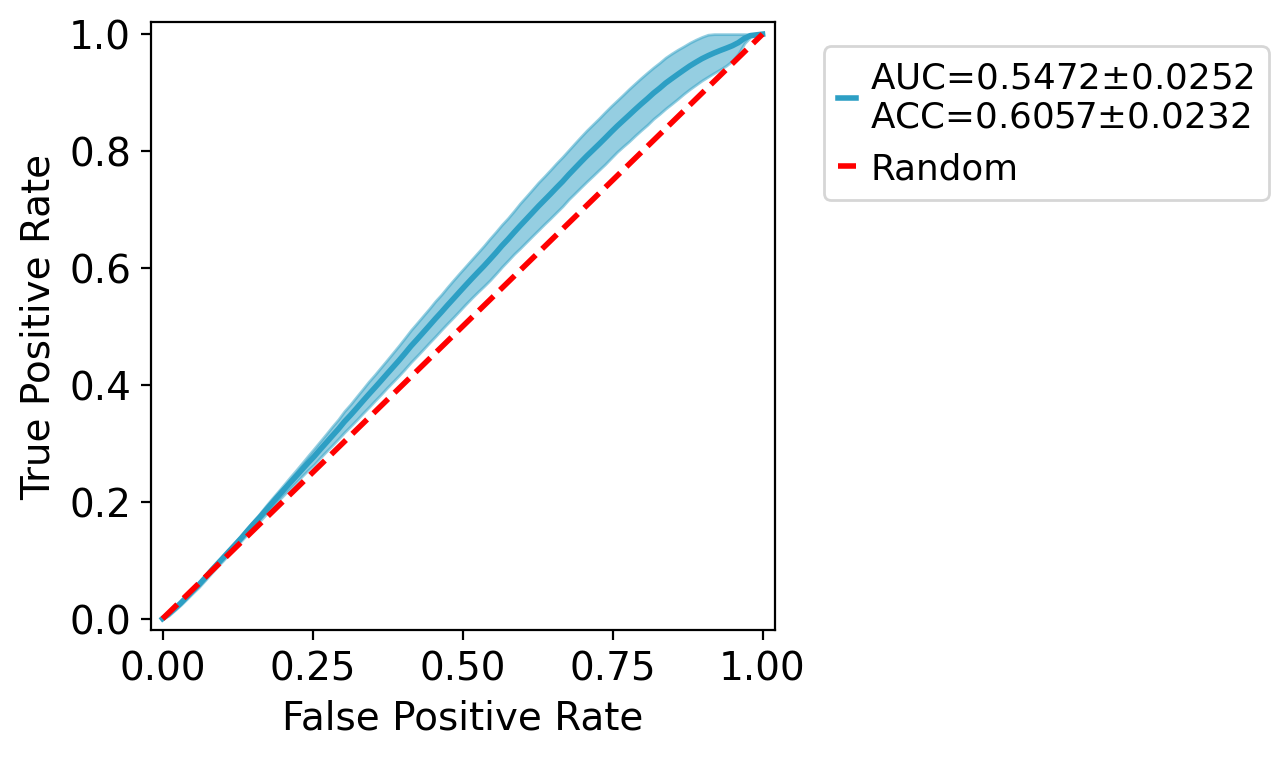

In [30]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [4]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [5]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Hard split (Test: only randomized negatives) - Train: only randomized negatives

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)

    # training
    train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')
    train = train[train['mhc.a'].isin(['HLA-A*02:01'])]
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    val = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/test/only-sampled-negs/test-{seed}.csv')
    val = val[val['mhc.a'].isin(['HLA-A*02:01'])]
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_24953/1129449004.py:11: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


0 | train 125232 val 12666


2023-11-01 03:46:33.999586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-01 03:46:33.999656: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-01 03:46:34.000390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3914/3914 [==============================] - 17s 4ms/step - loss: 0.5679 - accuracy: 0.7228 - auc: 0.7208 - val_loss: 0.6338 - val_accuracy: 0.6598 - val_auc: 0.5636
Epoch 2/10
3914/3914 [==============================] - 13s 3ms/step - loss: 0.5063 - accuracy: 0.7635 - auc: 0.7886 - val_loss: 0.6224 - val_accuracy: 0.6557 - val_auc: 0.5777
Epoch 3/10
3914/3914 [==============================] - 14s 4ms/step - loss: 0.4740 - accuracy: 0.7799 - auc: 0.8183 - val_loss: 0.6456 - val_accuracy: 0.6581 - val_auc: 0.5811
Epoch 4/10
3914/3914 [==============================] - 14s 4ms/step - loss: 0.4464 - accuracy: 0.7949 - auc: 0.8417 - val_loss: 0.6440 - val_accuracy: 0.6560 - val_auc: 0.5952
Epoch 5/10
3914/3914 [==============================] - 13s 3ms/step - loss: 0.4181 - accuracy: 0.8102 - auc: 0.8637 - val_loss: 0.6727 - val_accuracy: 0.6620 - val_auc: 0.6028
Epoch 6/10
3914/3914 [==============================] - 14s 3ms/step - loss: 0.3885 - accuracy: 0.8248 - auc: 0.884

/tmp/ipykernel_24953/1129449004.py:11: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


1 | train 118372 val 19526
Epoch 1/10
3700/3700 [==============================] - 15s 4ms/step - loss: 0.5669 - accuracy: 0.7223 - auc: 0.7242 - val_loss: 0.7089 - val_accuracy: 0.6179 - val_auc: 0.5232
Epoch 2/10
3700/3700 [==============================] - 15s 4ms/step - loss: 0.5091 - accuracy: 0.7635 - auc: 0.7870 - val_loss: 0.7326 - val_accuracy: 0.6303 - val_auc: 0.5210
Epoch 3/10
3700/3700 [==============================] - 15s 4ms/step - loss: 0.4749 - accuracy: 0.7810 - auc: 0.8182 - val_loss: 0.7811 - val_accuracy: 0.6268 - val_auc: 0.5231
Epoch 4/10
3700/3700 [==============================] - 14s 4ms/step - loss: 0.4445 - accuracy: 0.7978 - auc: 0.8433 - val_loss: 0.7975 - val_accuracy: 0.6281 - val_auc: 0.5266
Epoch 5/10
3700/3700 [==============================] - 14s 4ms/step - loss: 0.4158 - accuracy: 0.8126 - auc: 0.8654 - val_loss: 0.8449 - val_accuracy: 0.6268 - val_auc: 0.5353
Epoch 6/10
3700/3700 [==============================] - 16s 4ms/step - loss: 0.3849 - ac

/tmp/ipykernel_24953/1129449004.py:11: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


2 | train 134011 val 3887
Epoch 1/10
4188/4188 [==============================] - 17s 4ms/step - loss: 0.5685 - accuracy: 0.7205 - auc: 0.7193 - val_loss: 0.6814 - val_accuracy: 0.6391 - val_auc: 0.4840
Epoch 2/10
4188/4188 [==============================] - 15s 4ms/step - loss: 0.5113 - accuracy: 0.7584 - auc: 0.7842 - val_loss: 0.6547 - val_accuracy: 0.6509 - val_auc: 0.5212
Epoch 3/10
4188/4188 [==============================] - 14s 3ms/step - loss: 0.4791 - accuracy: 0.7760 - auc: 0.8138 - val_loss: 0.7006 - val_accuracy: 0.6529 - val_auc: 0.5334
Epoch 4/10
4188/4188 [==============================] - 16s 4ms/step - loss: 0.4511 - accuracy: 0.7921 - auc: 0.8376 - val_loss: 0.7492 - val_accuracy: 0.6547 - val_auc: 0.5505
Epoch 5/10
4188/4188 [==============================] - 15s 4ms/step - loss: 0.4240 - accuracy: 0.8050 - auc: 0.8595 - val_loss: 0.8812 - val_accuracy: 0.6537 - val_auc: 0.5416
Epoch 6/10
4188/4188 [==============================] - 16s 4ms/step - loss: 0.3969 - acc

/tmp/ipykernel_24953/1129449004.py:11: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


3 | train 126816 val 11082
Epoch 1/10
3963/3963 [==============================] - 17s 4ms/step - loss: 0.5667 - accuracy: 0.7235 - auc: 0.7225 - val_loss: 0.6359 - val_accuracy: 0.6604 - val_auc: 0.5707
Epoch 2/10
3963/3963 [==============================] - 15s 4ms/step - loss: 0.5086 - accuracy: 0.7611 - auc: 0.7869 - val_loss: 0.6724 - val_accuracy: 0.6749 - val_auc: 0.5618
Epoch 3/10
3963/3963 [==============================] - 15s 4ms/step - loss: 0.4748 - accuracy: 0.7797 - auc: 0.8175 - val_loss: 0.6813 - val_accuracy: 0.6615 - val_auc: 0.5444
Epoch 4/10
3963/3963 [==============================] - 15s 4ms/step - loss: 0.4453 - accuracy: 0.7951 - auc: 0.8426 - val_loss: 0.6666 - val_accuracy: 0.6662 - val_auc: 0.5983
Epoch 5/10
3963/3963 [==============================] - 15s 4ms/step - loss: 0.4152 - accuracy: 0.8113 - auc: 0.8659 - val_loss: 0.6918 - val_accuracy: 0.6634 - val_auc: 0.5768
Epoch 6/10
3963/3963 [==============================] - 16s 4ms/step - loss: 0.3859 - ac

/tmp/ipykernel_24953/1129449004.py:11: DtypeWarning: Columns (0,4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs/train-{seed}.csv')


4 | train 130400 val 7498
Epoch 1/10
4075/4075 [==============================] - 13s 3ms/step - loss: 0.5683 - accuracy: 0.7190 - auc: 0.7210 - val_loss: 0.6694 - val_accuracy: 0.6587 - val_auc: 0.5338
Epoch 2/10
4075/4075 [==============================] - 13s 3ms/step - loss: 0.5094 - accuracy: 0.7568 - auc: 0.7864 - val_loss: 0.6940 - val_accuracy: 0.6567 - val_auc: 0.5349
Epoch 3/10
4075/4075 [==============================] - 12s 3ms/step - loss: 0.4774 - accuracy: 0.7741 - auc: 0.8155 - val_loss: 0.7260 - val_accuracy: 0.6519 - val_auc: 0.5421
Epoch 4/10
4075/4075 [==============================] - 13s 3ms/step - loss: 0.4503 - accuracy: 0.7888 - auc: 0.8392 - val_loss: 0.7140 - val_accuracy: 0.6334 - val_auc: 0.5467
Epoch 5/10
4075/4075 [==============================] - 13s 3ms/step - loss: 0.4216 - accuracy: 0.8046 - auc: 0.8616 - val_loss: 0.7860 - val_accuracy: 0.6346 - val_auc: 0.5402
Epoch 6/10
4075/4075 [==============================] - 13s 3ms/step - loss: 0.3928 - acc

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

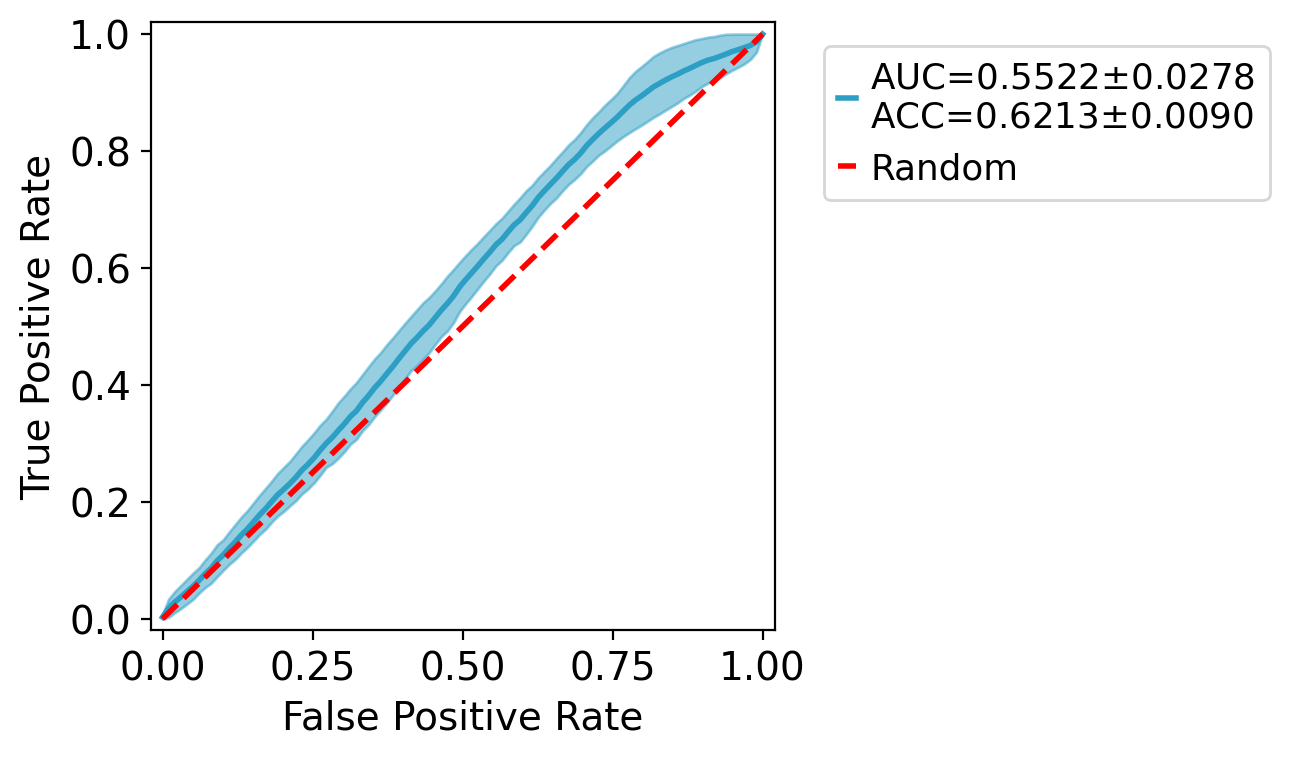

In [6]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [7]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Hard split (Test: only randomized negatives) - Train: negative assays + randomized negatives

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)

    # training
    train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')
    train = train[train['mhc.a'].isin(['HLA-A*02:01'])]
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    val = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/test/only-sampled-negs/test-{seed}.csv')
    val = val[val['mhc.a'].isin(['HLA-A*02:01'])]
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_24953/3663564822.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')


0 | train 251044 val 12666
Epoch 1/10
7846/7846 [==============================] - 26s 3ms/step - loss: 0.3685 - accuracy: 0.8458 - auc: 0.8034 - val_loss: 0.6382 - val_accuracy: 0.6596 - val_auc: 0.5819
Epoch 2/10
7846/7846 [==============================] - 25s 3ms/step - loss: 0.3348 - accuracy: 0.8638 - auc: 0.8390 - val_loss: 0.6399 - val_accuracy: 0.6590 - val_auc: 0.5752
Epoch 3/10
7846/7846 [==============================] - 24s 3ms/step - loss: 0.3173 - accuracy: 0.8710 - auc: 0.8554 - val_loss: 0.6465 - val_accuracy: 0.6581 - val_auc: 0.5922
Epoch 4/10
7846/7846 [==============================] - 25s 3ms/step - loss: 0.3021 - accuracy: 0.8787 - auc: 0.8689 - val_loss: 0.6644 - val_accuracy: 0.6483 - val_auc: 0.5822
Epoch 5/10
7846/7846 [==============================] - 25s 3ms/step - loss: 0.2872 - accuracy: 0.8855 - auc: 0.8816 - val_loss: 0.6848 - val_accuracy: 0.6133 - val_auc: 0.5749
Epoch 6/10
7846/7846 [==============================] - 25s 3ms/step - loss: 0.2726 - ac

/tmp/ipykernel_24953/3663564822.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')


1 | train 244184 val 19526
Epoch 1/10
7631/7631 [==============================] - 26s 3ms/step - loss: 0.3614 - accuracy: 0.8502 - auc: 0.8058 - val_loss: 0.6921 - val_accuracy: 0.6522 - val_auc: 0.5060
Epoch 2/10
7631/7631 [==============================] - 24s 3ms/step - loss: 0.3273 - accuracy: 0.8682 - auc: 0.8409 - val_loss: 0.6567 - val_accuracy: 0.6473 - val_auc: 0.5700
Epoch 3/10
7631/7631 [==============================] - 24s 3ms/step - loss: 0.3091 - accuracy: 0.8764 - auc: 0.8576 - val_loss: 0.6756 - val_accuracy: 0.6489 - val_auc: 0.5751
Epoch 4/10
7631/7631 [==============================] - 24s 3ms/step - loss: 0.2935 - accuracy: 0.8835 - auc: 0.8710 - val_loss: 0.7039 - val_accuracy: 0.6479 - val_auc: 0.5931
Epoch 5/10
7631/7631 [==============================] - 25s 3ms/step - loss: 0.2782 - accuracy: 0.8907 - auc: 0.8837 - val_loss: 0.7668 - val_accuracy: 0.6378 - val_auc: 0.5766
Epoch 6/10
7631/7631 [==============================] - 26s 3ms/step - loss: 0.2641 - ac

/tmp/ipykernel_24953/3663564822.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')


2 | train 259823 val 3887
Epoch 1/10
8120/8120 [==============================] - 33s 4ms/step - loss: 0.3768 - accuracy: 0.8394 - auc: 0.8022 - val_loss: 0.6270 - val_accuracy: 0.6483 - val_auc: 0.5443
Epoch 2/10
8120/8120 [==============================] - 31s 4ms/step - loss: 0.3405 - accuracy: 0.8587 - auc: 0.8400 - val_loss: 0.6156 - val_accuracy: 0.6529 - val_auc: 0.5536
Epoch 3/10
8120/8120 [==============================] - 32s 4ms/step - loss: 0.3217 - accuracy: 0.8672 - auc: 0.8572 - val_loss: 0.6266 - val_accuracy: 0.6252 - val_auc: 0.5599
Epoch 4/10
8120/8120 [==============================] - 32s 4ms/step - loss: 0.3069 - accuracy: 0.8749 - auc: 0.8698 - val_loss: 0.6214 - val_accuracy: 0.6190 - val_auc: 0.5889
Epoch 5/10
8120/8120 [==============================] - 32s 4ms/step - loss: 0.2923 - accuracy: 0.8819 - auc: 0.8820 - val_loss: 0.6627 - val_accuracy: 0.5969 - val_auc: 0.5626
Epoch 6/10
8120/8120 [==============================] - 31s 4ms/step - loss: 0.2783 - acc

/tmp/ipykernel_24953/3663564822.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')


3 | train 252628 val 11082
Epoch 1/10
7895/7895 [==============================] - 33s 4ms/step - loss: 0.3700 - accuracy: 0.8441 - auc: 0.8032 - val_loss: 0.6137 - val_accuracy: 0.6718 - val_auc: 0.6191
Epoch 2/10
7895/7895 [==============================] - 32s 4ms/step - loss: 0.3359 - accuracy: 0.8619 - auc: 0.8388 - val_loss: 0.6234 - val_accuracy: 0.6707 - val_auc: 0.6195
Epoch 3/10
7895/7895 [==============================] - 32s 4ms/step - loss: 0.3184 - accuracy: 0.8702 - auc: 0.8554 - val_loss: 0.6404 - val_accuracy: 0.6757 - val_auc: 0.6250
Epoch 4/10
7895/7895 [==============================] - 31s 4ms/step - loss: 0.3032 - accuracy: 0.8780 - auc: 0.8687 - val_loss: 0.6677 - val_accuracy: 0.6575 - val_auc: 0.5852
Epoch 5/10
7895/7895 [==============================] - 31s 4ms/step - loss: 0.2882 - accuracy: 0.8850 - auc: 0.8811 - val_loss: 0.6620 - val_accuracy: 0.6493 - val_auc: 0.6291
Epoch 6/10
7895/7895 [==============================] - 32s 4ms/step - loss: 0.2742 - ac

/tmp/ipykernel_24953/3663564822.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-sampled-negs.full/train-{seed}.csv')


4 | train 256212 val 7498
Epoch 1/10
8007/8007 [==============================] - 33s 4ms/step - loss: 0.3730 - accuracy: 0.8414 - auc: 0.8040 - val_loss: 0.6995 - val_accuracy: 0.6575 - val_auc: 0.5263
Epoch 2/10
8007/8007 [==============================] - 32s 4ms/step - loss: 0.3387 - accuracy: 0.8587 - auc: 0.8397 - val_loss: 0.6852 - val_accuracy: 0.6566 - val_auc: 0.5468
Epoch 3/10
8007/8007 [==============================] - 32s 4ms/step - loss: 0.3212 - accuracy: 0.8673 - auc: 0.8564 - val_loss: 0.7046 - val_accuracy: 0.6482 - val_auc: 0.5515
Epoch 4/10
8007/8007 [==============================] - 32s 4ms/step - loss: 0.3064 - accuracy: 0.8745 - auc: 0.8694 - val_loss: 0.7375 - val_accuracy: 0.6019 - val_auc: 0.5261
Epoch 5/10
8007/8007 [==============================] - 32s 4ms/step - loss: 0.2914 - accuracy: 0.8819 - auc: 0.8820 - val_loss: 0.7407 - val_accuracy: 0.5990 - val_auc: 0.5441
Epoch 6/10
8007/8007 [==============================] - 32s 4ms/step - loss: 0.2771 - acc

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

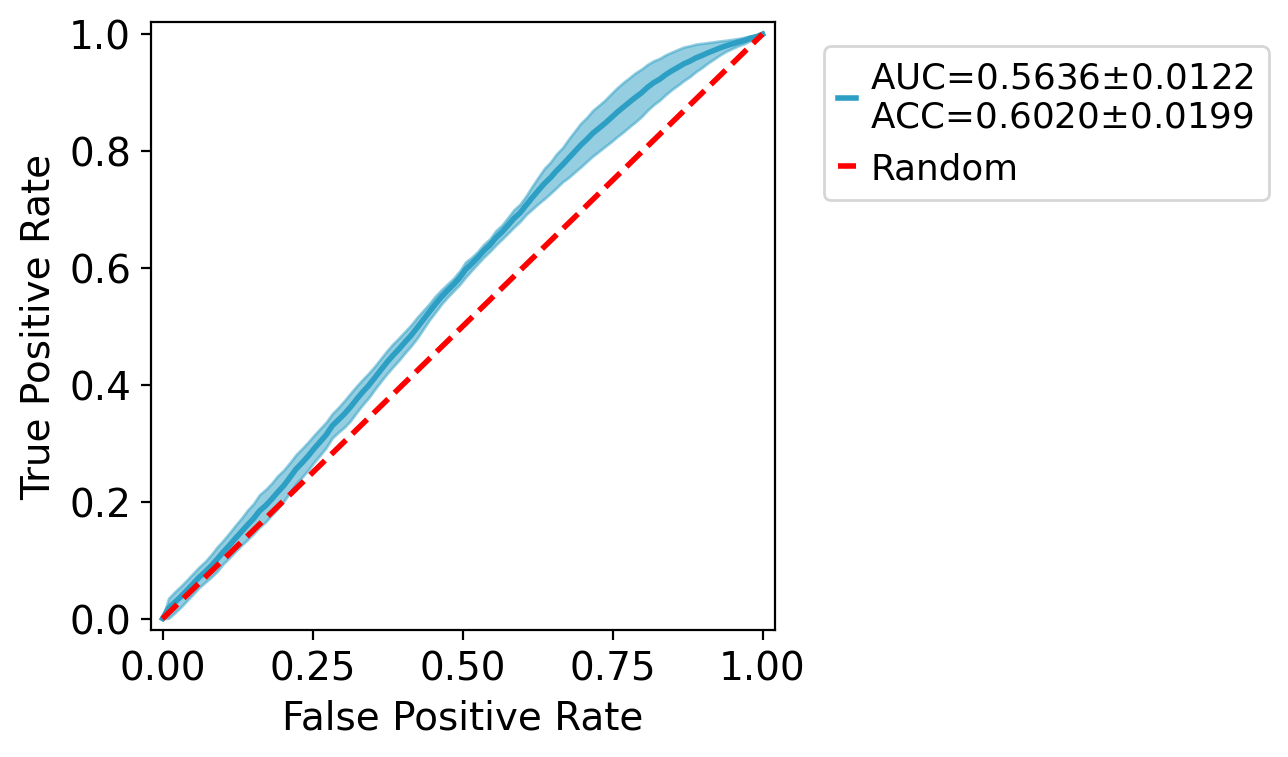

In [9]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [10]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Hard split (Test: only negative assays) - Train:  only negative assays

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)

    # training
    train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')
    train = train[train['mhc.a'].isin(['HLA-A*02:01'])]
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    val = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/test/only-neg-assays/test-{seed}.csv')
    val = val[val['mhc.a'].isin(['HLA-A*02:01'])]
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_24953/4179755207.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')


0 | train 157678 val 16843
Epoch 1/10
4928/4928 [==============================] - 22s 4ms/step - loss: 0.1880 - accuracy: 0.9457 - auc: 0.9216 - val_loss: 0.0270 - val_accuracy: 0.9888 - val_auc: 0.6971
Epoch 2/10
4928/4928 [==============================] - 21s 4ms/step - loss: 0.1667 - accuracy: 0.9522 - auc: 0.9375 - val_loss: 0.0134 - val_accuracy: 0.9939 - val_auc: 0.7075
Epoch 3/10
4928/4928 [==============================] - 20s 4ms/step - loss: 0.1582 - accuracy: 0.9546 - auc: 0.9447 - val_loss: 0.0182 - val_accuracy: 0.9923 - val_auc: 0.7105
Epoch 4/10
4928/4928 [==============================] - 20s 4ms/step - loss: 0.1498 - accuracy: 0.9564 - auc: 0.9520 - val_loss: 0.0059 - val_accuracy: 0.9984 - val_auc: 0.4841
Epoch 5/10
4928/4928 [==============================] - 20s 4ms/step - loss: 0.1401 - accuracy: 0.9584 - auc: 0.9596 - val_loss: 0.0116 - val_accuracy: 0.9951 - val_auc: 0.4728
Epoch 6/10
4928/4928 [==============================] - 21s 4ms/step - loss: 0.1286 - ac

/tmp/ipykernel_24953/4179755207.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')


1 | train 160215 val 14306
Epoch 1/10
5007/5007 [==============================] - 21s 4ms/step - loss: 0.1832 - accuracy: 0.9472 - auc: 0.9320 - val_loss: 0.3692 - val_accuracy: 0.8670 - val_auc: 0.9497
Epoch 2/10
5007/5007 [==============================] - 21s 4ms/step - loss: 0.1636 - accuracy: 0.9533 - auc: 0.9455 - val_loss: 0.8353 - val_accuracy: 0.8029 - val_auc: 0.7734
Epoch 3/10
5007/5007 [==============================] - 20s 4ms/step - loss: 0.1550 - accuracy: 0.9555 - auc: 0.9520 - val_loss: 0.7282 - val_accuracy: 0.8197 - val_auc: 0.7906
Epoch 4/10
5007/5007 [==============================] - 20s 4ms/step - loss: 0.1472 - accuracy: 0.9573 - auc: 0.9579 - val_loss: 0.6962 - val_accuracy: 0.8114 - val_auc: 0.8058
Epoch 5/10
5007/5007 [==============================] - 20s 4ms/step - loss: 0.1382 - accuracy: 0.9591 - auc: 0.9643 - val_loss: 0.8240 - val_accuracy: 0.8034 - val_auc: 0.7700
Epoch 6/10
5007/5007 [==============================] - 20s 4ms/step - loss: 0.1273 - ac

/tmp/ipykernel_24953/4179755207.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')


2 | train 161001 val 13520
Epoch 1/10
5032/5032 [==============================] - 22s 4ms/step - loss: 0.1840 - accuracy: 0.9471 - auc: 0.9304 - val_loss: 0.3472 - val_accuracy: 0.9131 - val_auc: 0.7697
Epoch 2/10
5032/5032 [==============================] - 20s 4ms/step - loss: 0.1632 - accuracy: 0.9535 - auc: 0.9443 - val_loss: 0.3123 - val_accuracy: 0.9198 - val_auc: 0.8184
Epoch 3/10
5032/5032 [==============================] - 20s 4ms/step - loss: 0.1549 - accuracy: 0.9555 - auc: 0.9507 - val_loss: 0.3724 - val_accuracy: 0.9318 - val_auc: 0.5735
Epoch 4/10
5032/5032 [==============================] - 21s 4ms/step - loss: 0.1462 - accuracy: 0.9573 - auc: 0.9574 - val_loss: 0.4315 - val_accuracy: 0.9196 - val_auc: 0.5020
Epoch 5/10
5032/5032 [==============================] - 20s 4ms/step - loss: 0.1369 - accuracy: 0.9595 - auc: 0.9642 - val_loss: 0.4956 - val_accuracy: 0.9242 - val_auc: 0.4528
Epoch 6/10
5032/5032 [==============================] - 21s 4ms/step - loss: 0.1263 - ac

/tmp/ipykernel_24953/4179755207.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')


3 | train 158300 val 16221
Epoch 1/10
4947/4947 [==============================] - 21s 4ms/step - loss: 0.1847 - accuracy: 0.9471 - auc: 0.9278 - val_loss: 0.1671 - val_accuracy: 0.9577 - val_auc: 0.9722
Epoch 2/10
4947/4947 [==============================] - 21s 4ms/step - loss: 0.1658 - accuracy: 0.9526 - auc: 0.9414 - val_loss: 0.2514 - val_accuracy: 0.9112 - val_auc: 0.9267
Epoch 3/10
4947/4947 [==============================] - 21s 4ms/step - loss: 0.1568 - accuracy: 0.9549 - auc: 0.9487 - val_loss: 0.3757 - val_accuracy: 0.8839 - val_auc: 0.8528
Epoch 4/10
4947/4947 [==============================] - 21s 4ms/step - loss: 0.1483 - accuracy: 0.9566 - auc: 0.9560 - val_loss: 0.3447 - val_accuracy: 0.8999 - val_auc: 0.8519
Epoch 5/10
4947/4947 [==============================] - 20s 4ms/step - loss: 0.1382 - accuracy: 0.9585 - auc: 0.9637 - val_loss: 0.3430 - val_accuracy: 0.8962 - val_auc: 0.8555
Epoch 6/10
4947/4947 [==============================] - 19s 4ms/step - loss: 0.1268 - ac

/tmp/ipykernel_24953/4179755207.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f'../external/tc-hard/ds.hard-splits/pep+cdr3b/train/only-neg-assays/train-{seed}.csv')


4 | train 164261 val 10260
Epoch 1/10
5134/5134 [==============================] - 21s 4ms/step - loss: 0.1790 - accuracy: 0.9489 - auc: 0.9356 - val_loss: 0.0112 - val_accuracy: 0.9938 - val_auc: 0.4814
Epoch 2/10
5134/5134 [==============================] - 21s 4ms/step - loss: 0.1601 - accuracy: 0.9542 - auc: 0.9483 - val_loss: 0.0173 - val_accuracy: 0.9902 - val_auc: 0.7168
Epoch 3/10
5134/5134 [==============================] - 21s 4ms/step - loss: 0.1512 - accuracy: 0.9564 - auc: 0.9550 - val_loss: 0.0118 - val_accuracy: 0.9939 - val_auc: 0.4772
Epoch 4/10
5134/5134 [==============================] - 21s 4ms/step - loss: 0.1429 - accuracy: 0.9582 - auc: 0.9611 - val_loss: 0.0036 - val_accuracy: 0.9998 - val_auc: 0.4899
Epoch 5/10
5134/5134 [==============================] - 21s 4ms/step - loss: 0.1334 - accuracy: 0.9600 - auc: 0.9676 - val_loss: 0.0053 - val_accuracy: 0.9996 - val_auc: 0.4842
Epoch 6/10
5134/5134 [==============================] - 20s 4ms/step - loss: 0.1232 - ac

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

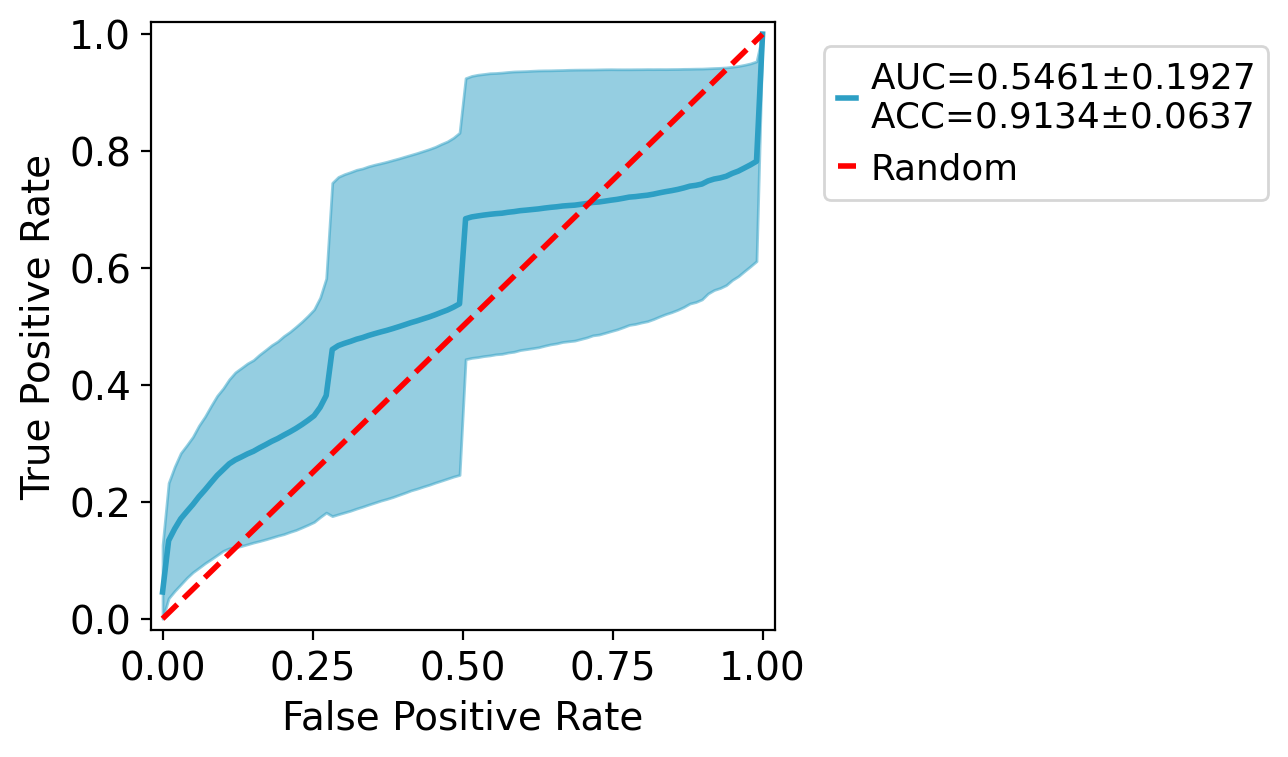

In [12]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [22]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [23]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split

# Random split - Train and test: only randomized negatives

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)
    
    # read in the data
    df = pd.read_csv('../external/tc-hard/ds.csv')
    df = df[df["mhc.a"] == "HLA-A*02:01"]
    df = df[df["negative.source"] != "mira"]
    df = df[df["negative.source"] != "iedb"]
    df = df[df["negative.source"] != "nettcr-2.0"]

    df = df.drop_duplicates(
        subset=["antigen.epitope", "cdr3.beta", "label"], keep="first"
    ).reset_index(drop=True)
    train, val = train_test_split(df, test_size=0.2, random_state=seed)
    
    # training
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_24953/284839302.py:12: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


0 | train 110437 val 27610
Epoch 1/10
3452/3452 [==============================] - 17s 5ms/step - loss: 0.5758 - accuracy: 0.7146 - auc: 0.7107 - val_loss: 0.5493 - val_accuracy: 0.7346 - val_auc: 0.7525
Epoch 2/10
3452/3452 [==============================] - 15s 4ms/step - loss: 0.5226 - accuracy: 0.7503 - auc: 0.7745 - val_loss: 0.5194 - val_accuracy: 0.7503 - val_auc: 0.7759
Epoch 3/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4895 - accuracy: 0.7672 - auc: 0.8058 - val_loss: 0.5044 - val_accuracy: 0.7607 - val_auc: 0.7892
Epoch 4/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4605 - accuracy: 0.7843 - auc: 0.8315 - val_loss: 0.5006 - val_accuracy: 0.7624 - val_auc: 0.7931
Epoch 5/10
3452/3452 [==============================] - 14s 4ms/step - loss: 0.4315 - accuracy: 0.8001 - auc: 0.8549 - val_loss: 0.5040 - val_accuracy: 0.7659 - val_auc: 0.7978
Epoch 6/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4031 - ac

/tmp/ipykernel_24953/284839302.py:12: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


1 | train 110436 val 27611
Epoch 1/10
3452/3452 [==============================] - 17s 5ms/step - loss: 0.5775 - accuracy: 0.7125 - auc: 0.7068 - val_loss: 0.5490 - val_accuracy: 0.7321 - val_auc: 0.7522
Epoch 2/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.5217 - accuracy: 0.7512 - auc: 0.7756 - val_loss: 0.5213 - val_accuracy: 0.7525 - val_auc: 0.7761
Epoch 3/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4896 - accuracy: 0.7676 - auc: 0.8054 - val_loss: 0.5056 - val_accuracy: 0.7599 - val_auc: 0.7894
Epoch 4/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4610 - accuracy: 0.7832 - auc: 0.8309 - val_loss: 0.5050 - val_accuracy: 0.7555 - val_auc: 0.7942
Epoch 5/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4338 - accuracy: 0.7979 - auc: 0.8530 - val_loss: 0.5031 - val_accuracy: 0.7651 - val_auc: 0.7979
Epoch 6/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4039 - ac

/tmp/ipykernel_24953/284839302.py:12: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


2 | train 110437 val 27610
Epoch 1/10
3452/3452 [==============================] - 16s 4ms/step - loss: 0.5788 - accuracy: 0.7116 - auc: 0.7056 - val_loss: 0.5445 - val_accuracy: 0.7386 - val_auc: 0.7549
Epoch 2/10
3452/3452 [==============================] - 15s 4ms/step - loss: 0.5222 - accuracy: 0.7495 - auc: 0.7749 - val_loss: 0.5165 - val_accuracy: 0.7556 - val_auc: 0.7791
Epoch 3/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4888 - accuracy: 0.7684 - auc: 0.8059 - val_loss: 0.5041 - val_accuracy: 0.7630 - val_auc: 0.7905
Epoch 4/10
3452/3452 [==============================] - 15s 4ms/step - loss: 0.4612 - accuracy: 0.7832 - auc: 0.8307 - val_loss: 0.5001 - val_accuracy: 0.7661 - val_auc: 0.7971
Epoch 5/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4331 - accuracy: 0.7999 - auc: 0.8535 - val_loss: 0.4960 - val_accuracy: 0.7692 - val_auc: 0.8025
Epoch 6/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4031 - ac

/tmp/ipykernel_24953/284839302.py:12: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


3 | train 110438 val 27609
Epoch 1/10
3452/3452 [==============================] - 17s 5ms/step - loss: 0.5783 - accuracy: 0.7120 - auc: 0.7069 - val_loss: 0.5431 - val_accuracy: 0.7383 - val_auc: 0.7552
Epoch 2/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.5240 - accuracy: 0.7477 - auc: 0.7737 - val_loss: 0.5143 - val_accuracy: 0.7571 - val_auc: 0.7783
Epoch 3/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4907 - accuracy: 0.7675 - auc: 0.8048 - val_loss: 0.4995 - val_accuracy: 0.7671 - val_auc: 0.7920
Epoch 4/10
3452/3452 [==============================] - 15s 4ms/step - loss: 0.4616 - accuracy: 0.7828 - auc: 0.8313 - val_loss: 0.4952 - val_accuracy: 0.7685 - val_auc: 0.7995
Epoch 5/10
3452/3452 [==============================] - 15s 4ms/step - loss: 0.4325 - accuracy: 0.7981 - auc: 0.8551 - val_loss: 0.4928 - val_accuracy: 0.7694 - val_auc: 0.8029
Epoch 6/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4013 - ac

/tmp/ipykernel_24953/284839302.py:12: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


4 | train 110436 val 27611
Epoch 1/10
3452/3452 [==============================] - 17s 5ms/step - loss: 0.5776 - accuracy: 0.7121 - auc: 0.7076 - val_loss: 0.5415 - val_accuracy: 0.7407 - val_auc: 0.7572
Epoch 2/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.5212 - accuracy: 0.7503 - auc: 0.7761 - val_loss: 0.5170 - val_accuracy: 0.7532 - val_auc: 0.7766
Epoch 3/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4888 - accuracy: 0.7685 - auc: 0.8062 - val_loss: 0.5043 - val_accuracy: 0.7616 - val_auc: 0.7888
Epoch 4/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4617 - accuracy: 0.7829 - auc: 0.8303 - val_loss: 0.5008 - val_accuracy: 0.7639 - val_auc: 0.7959
Epoch 5/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4347 - accuracy: 0.7990 - auc: 0.8526 - val_loss: 0.5051 - val_accuracy: 0.7592 - val_auc: 0.7973
Epoch 6/10
3452/3452 [==============================] - 16s 5ms/step - loss: 0.4064 - ac

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

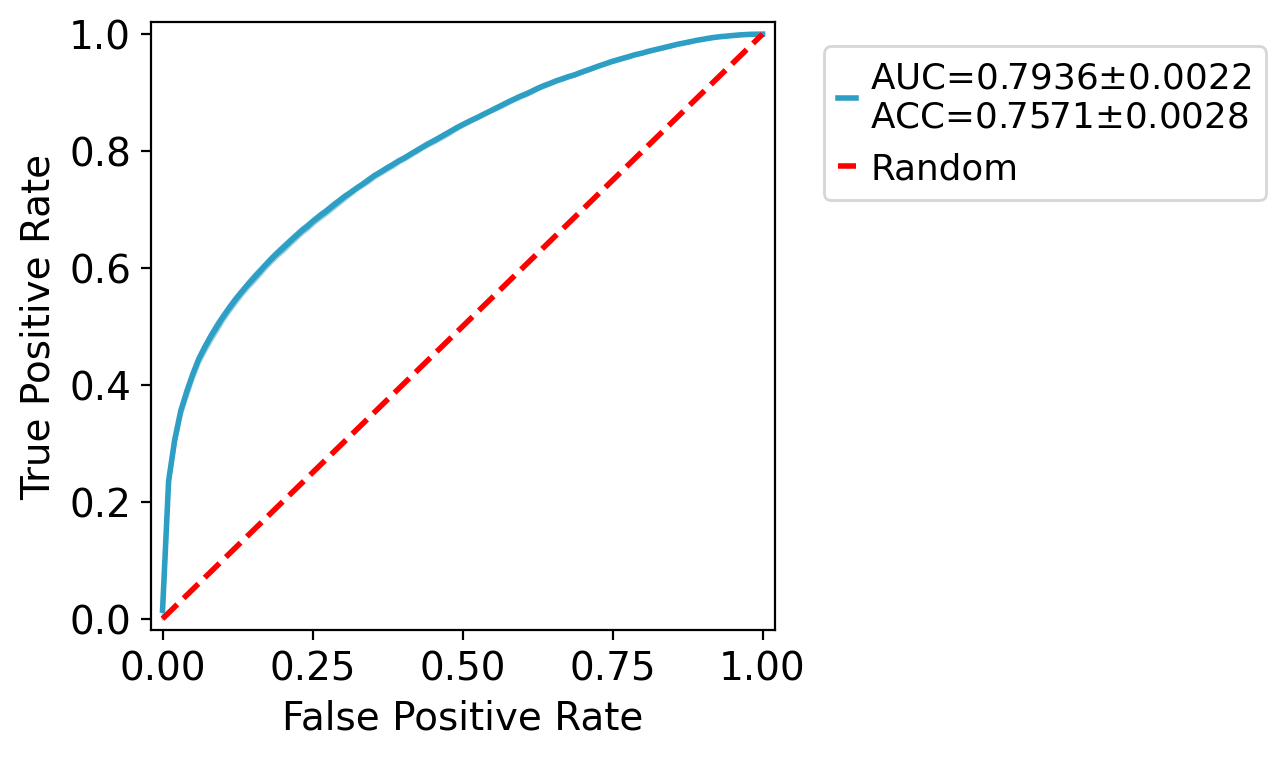

In [24]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [12]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [13]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Random split - Train and test: negative assays + randomized negatives

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)
    
    # read in the data
    df = pd.read_csv('../external/tc-hard/ds.csv')
    df = df[df["mhc.a"] == "HLA-A*02:01"]
    df = df.drop_duplicates(
        subset=["antigen.epitope", "cdr3.beta", "label"], keep="first"
    ).reset_index(drop=True)
    train, val = train_test_split(df, test_size=0.2, random_state=seed)
    
    # training
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_8770/2073920788.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


0 | train 210997 val 52750
Epoch 1/10
6594/6594 [==============================] - 29s 4ms/step - loss: 0.3860 - accuracy: 0.8334 - auc: 0.7933 - val_loss: 0.3627 - val_accuracy: 0.8464 - val_auc: 0.8225
Epoch 2/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.3495 - accuracy: 0.8529 - auc: 0.8340 - val_loss: 0.3492 - val_accuracy: 0.8520 - val_auc: 0.8352
Epoch 3/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.3302 - accuracy: 0.8630 - auc: 0.8522 - val_loss: 0.3451 - val_accuracy: 0.8555 - val_auc: 0.8407
Epoch 4/10
6594/6594 [==============================] - 26s 4ms/step - loss: 0.3140 - accuracy: 0.8706 - auc: 0.8666 - val_loss: 0.3457 - val_accuracy: 0.8555 - val_auc: 0.8404
Epoch 5/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.2981 - accuracy: 0.8782 - auc: 0.8805 - val_loss: 0.3478 - val_accuracy: 0.8563 - val_auc: 0.8386
Epoch 6/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.2819 - ac

/tmp/ipykernel_8770/2073920788.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


1 | train 210996 val 52751
Epoch 1/10
6594/6594 [==============================] - 31s 5ms/step - loss: 0.3838 - accuracy: 0.8347 - auc: 0.7960 - val_loss: 0.3625 - val_accuracy: 0.8464 - val_auc: 0.8244
Epoch 2/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.3475 - accuracy: 0.8537 - auc: 0.8351 - val_loss: 0.3468 - val_accuracy: 0.8542 - val_auc: 0.8383
Epoch 3/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.3296 - accuracy: 0.8626 - auc: 0.8521 - val_loss: 0.3447 - val_accuracy: 0.8555 - val_auc: 0.8404
Epoch 4/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.3136 - accuracy: 0.8701 - auc: 0.8664 - val_loss: 0.3424 - val_accuracy: 0.8577 - val_auc: 0.8433
Epoch 5/10
6594/6594 [==============================] - 29s 4ms/step - loss: 0.2982 - accuracy: 0.8777 - auc: 0.8795 - val_loss: 0.3430 - val_accuracy: 0.8599 - val_auc: 0.8407
Epoch 6/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.2824 - ac

/tmp/ipykernel_8770/2073920788.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


2 | train 210998 val 52749
Epoch 1/10
6594/6594 [==============================] - 31s 5ms/step - loss: 0.3849 - accuracy: 0.8341 - auc: 0.7968 - val_loss: 0.3626 - val_accuracy: 0.8470 - val_auc: 0.8202
Epoch 2/10
6594/6594 [==============================] - 29s 4ms/step - loss: 0.3495 - accuracy: 0.8520 - auc: 0.8352 - val_loss: 0.3469 - val_accuracy: 0.8536 - val_auc: 0.8342
Epoch 3/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.3311 - accuracy: 0.8610 - auc: 0.8523 - val_loss: 0.3414 - val_accuracy: 0.8575 - val_auc: 0.8395
Epoch 4/10
6594/6594 [==============================] - 26s 4ms/step - loss: 0.3153 - accuracy: 0.8686 - auc: 0.8665 - val_loss: 0.3419 - val_accuracy: 0.8608 - val_auc: 0.8392
Epoch 5/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.2994 - accuracy: 0.8762 - auc: 0.8799 - val_loss: 0.3408 - val_accuracy: 0.8595 - val_auc: 0.8403
Epoch 6/10
6594/6594 [==============================] - 28s 4ms/step - loss: 0.2833 - ac

/tmp/ipykernel_8770/2073920788.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


3 | train 210996 val 52751
Epoch 1/10
6594/6594 [==============================] - 32s 5ms/step - loss: 0.3859 - accuracy: 0.8335 - auc: 0.7943 - val_loss: 0.3597 - val_accuracy: 0.8474 - val_auc: 0.8257
Epoch 2/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.3505 - accuracy: 0.8530 - auc: 0.8332 - val_loss: 0.3466 - val_accuracy: 0.8530 - val_auc: 0.8388
Epoch 3/10
6594/6594 [==============================] - 29s 4ms/step - loss: 0.3315 - accuracy: 0.8611 - auc: 0.8513 - val_loss: 0.3433 - val_accuracy: 0.8563 - val_auc: 0.8398
Epoch 4/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.3160 - accuracy: 0.8690 - auc: 0.8655 - val_loss: 0.3404 - val_accuracy: 0.8571 - val_auc: 0.8444
Epoch 5/10
6594/6594 [==============================] - 26s 4ms/step - loss: 0.3009 - accuracy: 0.8765 - auc: 0.8783 - val_loss: 0.3411 - val_accuracy: 0.8584 - val_auc: 0.8423
Epoch 6/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.2855 - ac

/tmp/ipykernel_8770/2073920788.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


4 | train 210997 val 52750
Epoch 1/10
6594/6594 [==============================] - 31s 5ms/step - loss: 0.3852 - accuracy: 0.8342 - auc: 0.7940 - val_loss: 0.3625 - val_accuracy: 0.8430 - val_auc: 0.8260
Epoch 2/10
6594/6594 [==============================] - 26s 4ms/step - loss: 0.3495 - accuracy: 0.8531 - auc: 0.8336 - val_loss: 0.3499 - val_accuracy: 0.8524 - val_auc: 0.8373
Epoch 3/10
6594/6594 [==============================] - 27s 4ms/step - loss: 0.3311 - accuracy: 0.8615 - auc: 0.8510 - val_loss: 0.3442 - val_accuracy: 0.8547 - val_auc: 0.8430
Epoch 4/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.3155 - accuracy: 0.8687 - auc: 0.8650 - val_loss: 0.3475 - val_accuracy: 0.8573 - val_auc: 0.8434
Epoch 5/10
6594/6594 [==============================] - 28s 4ms/step - loss: 0.3001 - accuracy: 0.8764 - auc: 0.8786 - val_loss: 0.3451 - val_accuracy: 0.8570 - val_auc: 0.8420
Epoch 6/10
6594/6594 [==============================] - 30s 5ms/step - loss: 0.2842 - ac

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

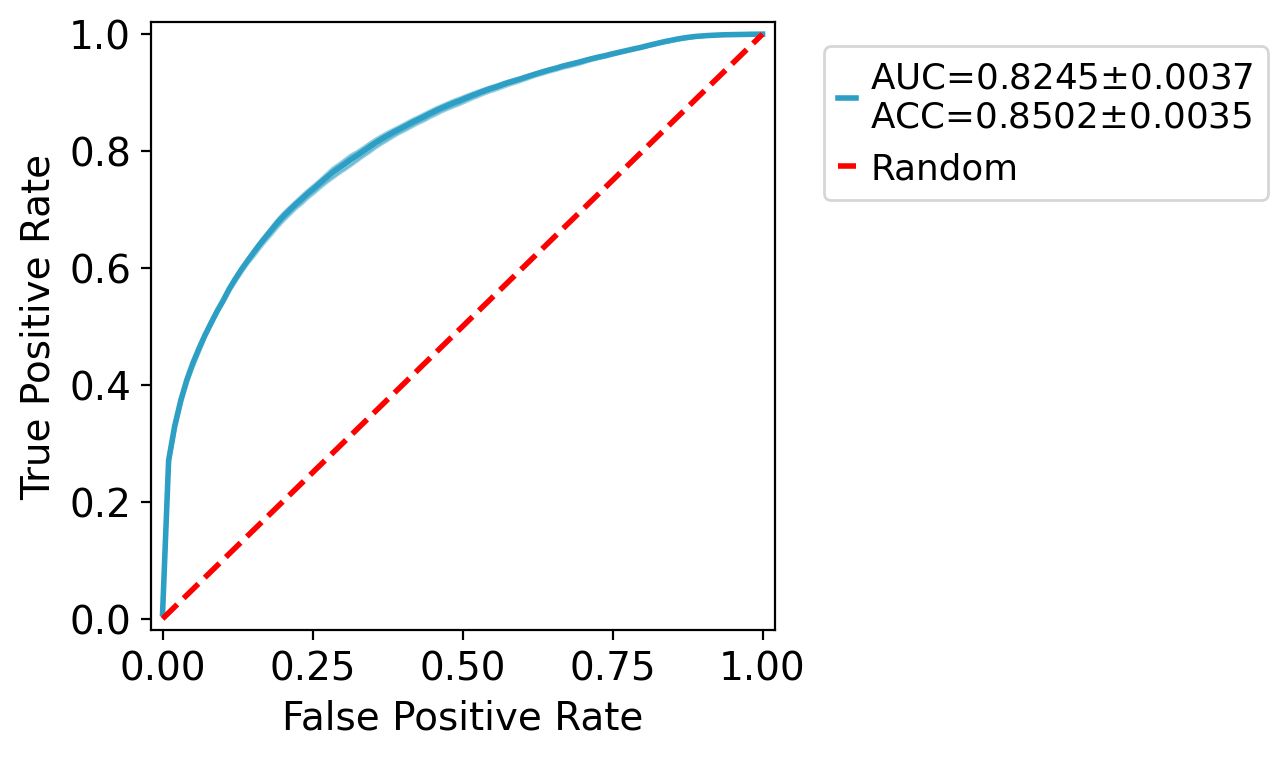

In [14]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [9]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [10]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Random split - Train and test: only negative assays

# complete all five iterations
for seed in range(5):
    # grab a subset
    np.random.seed(seed)
    
    # read in the data
    df = pd.read_csv('../external/tc-hard/ds.csv')
    df = df[df["mhc.a"] == "HLA-A*02:01"]
    df = df[df["negative.source"] != "randomized"]
    df = df.drop_duplicates(
        subset=["antigen.epitope", "cdr3.beta", "label"], keep="first"
    ).reset_index(drop=True)
    train, val = train_test_split(df, test_size=0.2, random_state=seed)
    
    # training
    X_train = train[['cdr3.beta','antigen.epitope']]
    X_train.columns = ['CDR3','Epitope']
    y_train = train['label']
    
    # validation
    X_val = val[['cdr3.beta','antigen.epitope']]
    X_val.columns = ['CDR3','Epitope']
    y_val = val['label']
    
    # discard aberrant amino acids
    import string
    invalid_aas = [aa for aa in string.ascii_uppercase if aa not in amino_acid_charge]
    for invalid_aa in invalid_aas:
        # remove from training
        mask = X_train['CDR3'].apply(lambda x: invalid_aa in x)
        X_train = X_train.loc[~mask].reset_index().iloc[:, 1:]
        y_train = y_train.loc[~mask].reset_index().iloc[:, 1]
        # remove from validation
        mask = X_val['CDR3'].apply(lambda x: invalid_aa in x)
        X_val = X_val.loc[~mask].reset_index().iloc[:, 1:]
        y_val = y_val.loc[~mask].reset_index().iloc[:, 1]

    # create encoders
    print(seed, '|', 'train', X_train.shape[0], 'val', X_val.shape[0])
    X_cdr3s = encode_cdr3s(pd.concat([X_train, X_val], axis=0)['CDR3'].unique(), 40, False)
    X_epitopes = encode_ags(pd.concat([X_train, X_val], axis=0)['Epitope'].unique(), 40, False)
    
    # create X for training
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # create X for validation
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # read in normalization factors
    means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
    stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
    # subset for relevant columns
    X_train = X_train[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred['label'], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred['label'], y_pred['Pred%'].apply(round)))

/tmp/ipykernel_8770/1351858323.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


0 | train 139644 val 34912


2023-11-01 08:24:01.122786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-01 08:24:01.122835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-01 08:24:01.123254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
4364/4364 [==============================] - 22s 5ms/step - loss: 0.1704 - accuracy: 0.9514 - auc: 0.9481 - val_loss: 0.1595 - val_accuracy: 0.9544 - val_auc: 0.9547
Epoch 2/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1514 - accuracy: 0.9566 - auc: 0.9587 - val_loss: 0.1547 - val_accuracy: 0.9559 - val_auc: 0.9567
Epoch 3/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1422 - accuracy: 0.9590 - auc: 0.9648 - val_loss: 0.1563 - val_accuracy: 0.9563 - val_auc: 0.9577
Epoch 4/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1330 - accuracy: 0.9607 - auc: 0.9707 - val_loss: 0.1556 - val_accuracy: 0.9567 - val_auc: 0.9576
Epoch 5/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1217 - accuracy: 0.9632 - auc: 0.9767 - val_loss: 0.1621 - val_accuracy: 0.9547 - val_auc: 0.9559
Epoch 6/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1094 - accuracy: 0.9656 - auc: 0.982

/tmp/ipykernel_8770/1351858323.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


1 | train 139644 val 34912
Epoch 1/10
4364/4364 [==============================] - 21s 5ms/step - loss: 0.1699 - accuracy: 0.9512 - auc: 0.9483 - val_loss: 0.1601 - val_accuracy: 0.9544 - val_auc: 0.9555
Epoch 2/10
4364/4364 [==============================] - 20s 4ms/step - loss: 0.1510 - accuracy: 0.9570 - auc: 0.9588 - val_loss: 0.1553 - val_accuracy: 0.9555 - val_auc: 0.9581
Epoch 3/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1423 - accuracy: 0.9589 - auc: 0.9645 - val_loss: 0.1539 - val_accuracy: 0.9564 - val_auc: 0.9578
Epoch 4/10
4364/4364 [==============================] - 20s 4ms/step - loss: 0.1334 - accuracy: 0.9607 - auc: 0.9702 - val_loss: 0.1596 - val_accuracy: 0.9561 - val_auc: 0.9567
Epoch 5/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1231 - accuracy: 0.9630 - auc: 0.9758 - val_loss: 0.1639 - val_accuracy: 0.9562 - val_auc: 0.9552
Epoch 6/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1114 - ac

/tmp/ipykernel_8770/1351858323.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


2 | train 139644 val 34912
Epoch 1/10
4364/4364 [==============================] - 21s 5ms/step - loss: 0.1705 - accuracy: 0.9511 - auc: 0.9482 - val_loss: 0.1577 - val_accuracy: 0.9552 - val_auc: 0.9551
Epoch 2/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1510 - accuracy: 0.9568 - auc: 0.9590 - val_loss: 0.1527 - val_accuracy: 0.9568 - val_auc: 0.9581
Epoch 3/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1428 - accuracy: 0.9590 - auc: 0.9642 - val_loss: 0.1534 - val_accuracy: 0.9566 - val_auc: 0.9574
Epoch 4/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1341 - accuracy: 0.9607 - auc: 0.9698 - val_loss: 0.1567 - val_accuracy: 0.9573 - val_auc: 0.9578
Epoch 5/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1242 - accuracy: 0.9628 - auc: 0.9754 - val_loss: 0.1565 - val_accuracy: 0.9574 - val_auc: 0.9572
Epoch 6/10
4364/4364 [==============================] - 20s 5ms/step - loss: 0.1122 - ac

/tmp/ipykernel_8770/1351858323.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


3 | train 139644 val 34912
Epoch 1/10
4364/4364 [==============================] - 21s 5ms/step - loss: 0.1700 - accuracy: 0.9514 - auc: 0.9481 - val_loss: 0.1644 - val_accuracy: 0.9539 - val_auc: 0.9547
Epoch 2/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1514 - accuracy: 0.9567 - auc: 0.9588 - val_loss: 0.1569 - val_accuracy: 0.9552 - val_auc: 0.9566
Epoch 3/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1429 - accuracy: 0.9587 - auc: 0.9644 - val_loss: 0.1564 - val_accuracy: 0.9557 - val_auc: 0.9566
Epoch 4/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1342 - accuracy: 0.9605 - auc: 0.9697 - val_loss: 0.1570 - val_accuracy: 0.9562 - val_auc: 0.9568
Epoch 5/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1236 - accuracy: 0.9627 - auc: 0.9759 - val_loss: 0.1641 - val_accuracy: 0.9563 - val_auc: 0.9554
Epoch 6/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1113 - ac

/tmp/ipykernel_8770/1351858323.py:11: DtypeWarning: Columns (0,4,5,6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../external/tc-hard/ds.csv')


4 | train 139644 val 34912
Epoch 1/10
4364/4364 [==============================] - 19s 4ms/step - loss: 0.1730 - accuracy: 0.9505 - auc: 0.9470 - val_loss: 0.1539 - val_accuracy: 0.9570 - val_auc: 0.9564
Epoch 2/10
4364/4364 [==============================] - 18s 4ms/step - loss: 0.1532 - accuracy: 0.9561 - auc: 0.9580 - val_loss: 0.1487 - val_accuracy: 0.9580 - val_auc: 0.9591
Epoch 3/10
4364/4364 [==============================] - 18s 4ms/step - loss: 0.1445 - accuracy: 0.9581 - auc: 0.9640 - val_loss: 0.1465 - val_accuracy: 0.9587 - val_auc: 0.9604
Epoch 4/10
4364/4364 [==============================] - 18s 4ms/step - loss: 0.1358 - accuracy: 0.9598 - auc: 0.9695 - val_loss: 0.1493 - val_accuracy: 0.9589 - val_auc: 0.9601
Epoch 5/10
4364/4364 [==============================] - 18s 4ms/step - loss: 0.1255 - accuracy: 0.9617 - auc: 0.9754 - val_loss: 0.1529 - val_accuracy: 0.9584 - val_auc: 0.9587
Epoch 6/10
4364/4364 [==============================] - 17s 4ms/step - loss: 0.1134 - ac

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

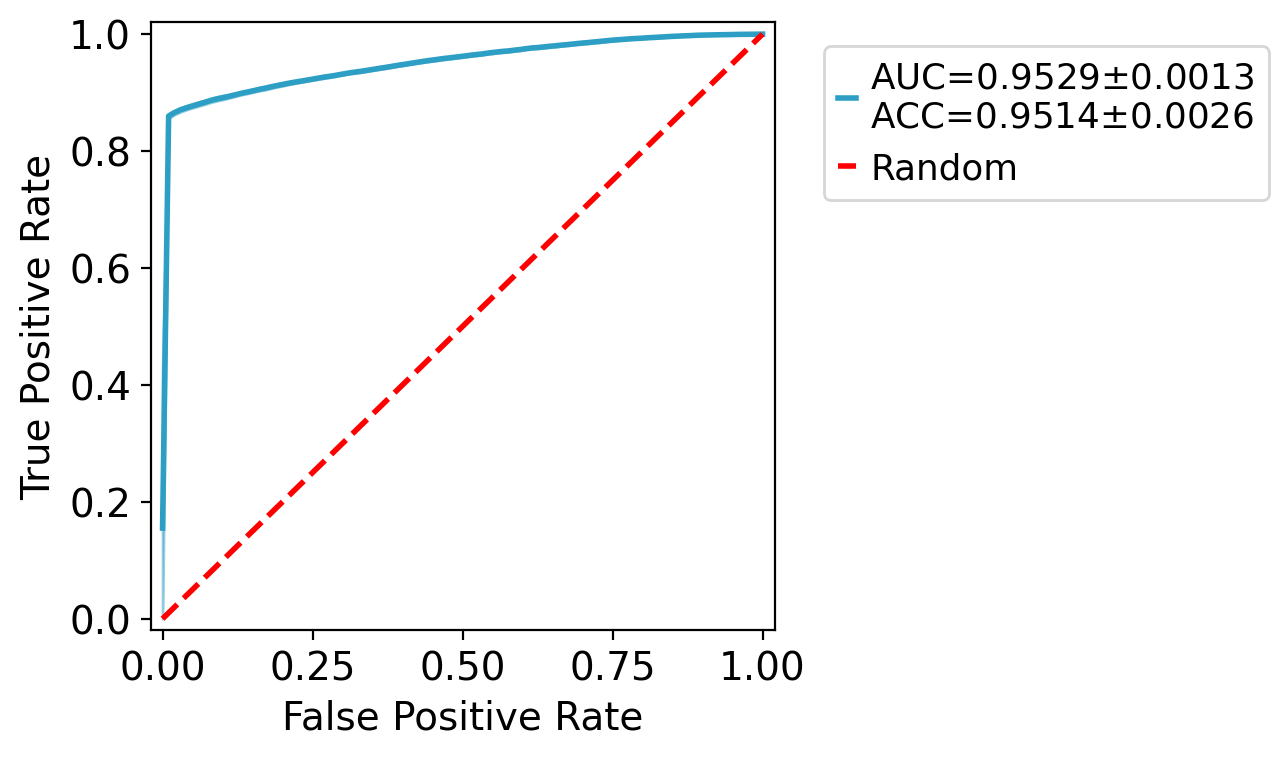

In [11]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')